#  **Project: RemoteOps AI**
### **AI-Based Employee Behavior Anomaly Detection System**

**Author:** Teena

**Tech Stack:** Python, TensorFlow (Keras), Sentence-Transformers (SBERT), Scikit-Learn

---
###  **Project Overview**
This project solves the "Remote Visibility" problem without invasive surveillance.

It uses **Unsupervised Deep Learning** to detect two types of anomalies in engineering teams:
1.  **Burnout Risk:** Employees working unsustainably high hours.
2.  **Quiet Quitting / Fraud:** Mismatches between reported Jira tasks and actual Git code output.

**The Pipeline:**
1.  **Generate Synthetic Data:** Simulate a 5-person Software engineering team with realistic work patterns.
2.  **Model Face-Off:** Benchmark a simple **Isolation Forest** against a Deep **Autoencoder**.
3.  **Semantic Audit:** Use **SBERT (NLP)** to cross-reference Jira tickets vs. Git commits.
4.  **Risk Dashboard:** Classify employees into risk quadrants (Safe, Burnout, Slacking).




In [19]:
import pandas as pd
import numpy as np
import random
import seaborn as sns

##  **Step 1: Synthetic Data Generation**
Since real employee performance data is sensitive/private, we generate a **Synthetic Dataset** , Using Faker library from Python to train our models.

**Simulation Logic:**
* **Normal Employees:** Work ~8 hours, close ~1-2 tickets, commit code that matches tasks.

* **Burnout Risks:** Work 10-16 hours, high code volume (simulated with `np.random.uniform`).

* **Slackers:** Work <3 hours, low code volume, potentially mismatched commit logs.

In [20]:
from faker import Faker

fake = Faker()
np.random.seed(42)

NUM_EMPLOYEES = 5
DAYS_PER_EMPLOYEE = 60

data = []

for emp_id in range(1, NUM_EMPLOYEES + 1):
    name = fake.name()
    role = random.choice(['Backend Dev', 'Frontend Dev', 'Data Scientist'])

    dates = pd.date_range(start='2024-01-01', periods=DAYS_PER_EMPLOYEE, freq='B') # 'B' means Business Days (Mon-Fri)

    for date in dates:
        hours_worked = np.random.normal(loc=8.0, scale=1.0)

        lines_changed = int(hours_worked * 20 + np.random.normal(0, 20))
        lines_changed = max(0, lines_changed)

        tickets_closed = np.random.poisson(lam=1.5)


        if random.random() < 0.05:
            hours_worked = np.random.uniform(10, 16)
            lines_changed = lines_changed * 2
            anomaly_type = "Burnout Risk"

        elif random.random() < 0.03:
            hours_worked = np.random.uniform(0.5, 3)
            lines_changed = np.random.randint(0, 10)
            anomaly_type = "Slacking"
        else:
            anomaly_type = "Normal"

        data.append({
            'Employee_ID': f"EMP_{emp_id:03d}",
            'Name': name,
            'Role': role,
            'Date': date,
            'Hours_Worked': round(hours_worked, 2),
            'Lines_Changed': lines_changed,
            'Tickets_Closed': tickets_closed,
            'Label': anomaly_type
        })

df_behavior = pd.DataFrame(data)

print("Data Generation Complete!")
print(f"Total Rows Generated: {len(df_behavior)}")
df_behavior.head(10)

Data Generation Complete!
Total Rows Generated: 300


,Employee_ID,Name,Role,Date,Hours_Worked,Lines_Changed,Tickets_Closed,Label
0,EMP_001,Cathy Woods,Frontend Dev,2024-01-01,8.50,167,2,Normal
1,EMP_001,Cathy Woods,Frontend Dev,2024-01-02,8.28,185,1,Normal
2,EMP_001,Cathy Woods,Frontend Dev,2024-01-03,7.42,137,0,Normal
3,EMP_001,Cathy Woods,Frontend Dev,2024-01-04,8.24,126,1,Normal
4,EMP_001,Cathy Woods,Frontend Dev,2024-01-05,6.99,146,1,Normal
5,EMP_001,Cathy Woods,Frontend Dev,2024-01-08,9.47,184,0,Normal
6,EMP_001,Cathy Woods,Frontend Dev,2024-01-09,10.56,219,0,Normal
7,EMP_001,Cathy Woods,Frontend Dev,2024-01-10,6.85,144,0,Normal
8,EMP_001,Cathy Woods,Frontend Dev,2024-01-11,14.11,332,0,Burnout Risk
9,EMP_001,Cathy Woods,Frontend Dev,2024-01-12,6.98,136,1,Normal


In [21]:
task_clusters = {
    "Backend": {
        "jira": [
            "Fix authentication memory leak",
            "Optimize database queries for dashboard",
            "Implement API rate limiting",
            "Upgrade Python version to 3.11"
        ],
        "git": [
            "Fixed memory leak in auth_service.py",
            "Added index to users table for speed",
            "Added Redis for rate limiting",
            "Updated Dockerfile to python:3.11-slim"
        ]
    },
    "Frontend": {
        "jira": [
            "Center the login button",
            "Fix CSS grid on mobile view",
            "Add dark mode toggle",
            "Update React dependencies"
        ],
        "git": [
            "Changed margin-left to auto in login.css",
            "Added media queries for mobile responsiveness",
            "Created ThemeContext for dark mode",
            "Ran npm audit fix and updated package.json"
        ]
    }
}

text_data = []

for index, row in df_behavior.iterrows():

    topic_keys = list(task_clusters.keys())
    chosen_topic = random.choice(topic_keys)

    jira_task = random.choice(task_clusters[chosen_topic]["jira"])

    is_mismatch = False
    if row['Label'] != 'Normal' and random.random() < 0.3:
        is_mismatch = True

    if is_mismatch:
        wrong_topic = [t for t in topic_keys if t != chosen_topic][0]
        git_commit = random.choice(task_clusters[wrong_topic]["git"])
        match_label = "Mismatch"
    else:
        git_commit = random.choice(task_clusters[chosen_topic]["git"])
        match_label = "Match"

    text_data.append({
        'Date': row['Date'],
        'Employee_ID': row['Employee_ID'],
        'Jira_Task': jira_task,
        'Git_Commit': git_commit,
        'Task_Alignment': match_label
    })

df_text = pd.DataFrame(text_data)

df_final = pd.merge(df_behavior, df_text, on=['Date', 'Employee_ID'])

print("Text Generation Complete!")
df_final[['Date', 'Label', 'Jira_Task', 'Git_Commit', 'Task_Alignment']].head(10)

Text Generation Complete!


,Date,Label,Jira_Task,Git_Commit,Task_Alignment
0,2024-01-01,Normal,Update React dependencies,Ran npm audit fix and updated package.json,Match
1,2024-01-02,Normal,Add dark mode toggle,Added media queries for mobile responsiveness,Match
2,2024-01-03,Normal,Fix authentication memory leak,Updated Dockerfile to python:3.11-slim,Match
3,2024-01-04,Normal,Center the login button,Changed margin-left to auto in login.css,Match
4,2024-01-05,Normal,Fix authentication memory leak,Added Redis for rate limiting,Match
5,2024-01-08,Normal,Fix authentication memory leak,Added Redis for rate limiting,Match
6,2024-01-09,Normal,Implement API rate limiting,Added Redis for rate limiting,Match
7,2024-01-10,Normal,Fix authentication memory leak,Added Redis for rate limiting,Match
8,2024-01-11,Burnout Risk,Fix authentication memory leak,Added Redis for rate limiting,Match
9,2024-01-12,Normal,Center the login button,Ran npm audit fix and updated package.json,Match


##  **Step 2: Preprocessing & Machine Learning Model**
In this stage, we prepare the raw data for analysis and deploy our first detection algorithm.

**1. Data Preprocessing:**
We use `MinMaxScaler` to scale all behavioral features (Hours, Lines Changed, Tickets) into a normalized range of 0 to 1. This is a critical step to ensure that features with larger numbers (like "Lines of Code") don't bias the model.

**2. Initial Model (Isolation Forest):**
We run an **Isolation Forest** on this preprocessed data. This unsupervised Machine Learning model detects anomalies by randomly splitting the data points.
* **Goal:** To identify immediate, statistical outliers in the dataset before exploring complex patterns.

In [22]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.ensemble import IsolationForest

print("2a. Preprocessing & Using IsolationForest")

features = ["Hours_Worked", "Lines_Changed", "Tickets_Closed"]
scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(df_final[features])

print(" Training Isolation Forest...")
iso_forest = IsolationForest(n_estimators=100, contamination=0.05, random_state=42)
iso_labels = iso_forest.fit_predict(X_scaled)

df_final['IsoForest_Anomaly'] = [1 if x == -1 else 0 for x in iso_labels]
iso_anomalies = df_final[df_final['IsoForest_Anomaly'] == 1]

print(f"Isolation Forest found {len(iso_anomalies)} anomalies out of {len(df_final)} records.")
print("\nTop 5 People Caught by ML:")
print(iso_anomalies[['Date', 'Label', 'Hours_Worked', 'IsoForest_Anomaly']].head())


2a. Preprocessing & Using IsolationForest
 Training Isolation Forest...
Isolation Forest found 15 anomalies out of 300 records.

Top 5 People Caught by ML:
          Date         Label  Hours_Worked  IsoForest_Anomaly
11  2024-01-16      Slacking          2.92                  1
40  2024-02-26  Burnout Risk         11.83                  1
80  2024-01-29  Burnout Risk         13.21                  1
86  2024-02-06  Burnout Risk         14.66                  1
100 2024-02-26        Normal          7.89                  1


##  **Step 3: Deep Learning Setup (Autoencoder)**
We now prepare the data for the **Neural Network**.

**Training Strategy (Semi-Supervised):**
* **Train Set:** We train the model **ONLY on Normal Data**. This teaches the AI exactly what "Good Behavior" looks like.
* **Test Set:** We test on **Everyone** (Normal + Anomalies).
* **The Logic:** If the model only knows what "Good" looks like, it will be confused (high error) when it sees "Bad" behavior.

**“In many real-world systems, ML models like Isolation Forest are sufficient. Deep Learning is added here to capture complex, non-linear behavior patterns and to compare performance.”**

In [23]:
from sklearn.model_selection import train_test_split

print("2b. Preparing Data for Autoencoder...")

normal_indices = df_final[df_final['Label'] == 'Normal'].index
X_normal = X_scaled[normal_indices]

X_train, _ = train_test_split(X_normal, test_size=0.2, random_state=42)
X_test = X_scaled

print(f"   - Training Shape (Normal Only): {X_train.shape}")
print(f"   - Testing Shape (Everyone): {X_test.shape}")

2b. Preparing Data for Autoencoder...
   - Training Shape (Normal Only): (216, 3)
   - Testing Shape (Everyone): (300, 3)


### **The Autoencoder Architecture**
We build a **Dense Neural Network** that compresses data and tries to reconstruct it.
* **Encoder:** Compresses 3 features -> 2 latent numbers (The "bottleneck").
* **Decoder:** Tries to recreate the original 3 features from the compressed version.
* **Reconstruction Error (MSE):** The difference between Input and Output.
    * *Low Error* = Normal Behavior.
    * *High Error* = Anomaly!

Starting Training...
Epoch 1/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - loss: 0.0480 - val_loss: 0.0465
Epoch 2/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0414 - val_loss: 0.0412
Epoch 3/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0351 - val_loss: 0.0365
Epoch 4/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0310 - val_loss: 0.0324
Epoch 5/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0260 - val_loss: 0.0289
Epoch 6/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0233 - val_loss: 0.0258
Epoch 7/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0182 - val_loss: 0.0233
Epoch 8/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0171 - val_loss: 0.0211
Epoch 9/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0163 - val_loss: 0.0194
Epoch 10/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0131 - val_loss: 0.0181
Epoch 11/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0115 - val_loss: 0.0170
Epoch 12/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step -

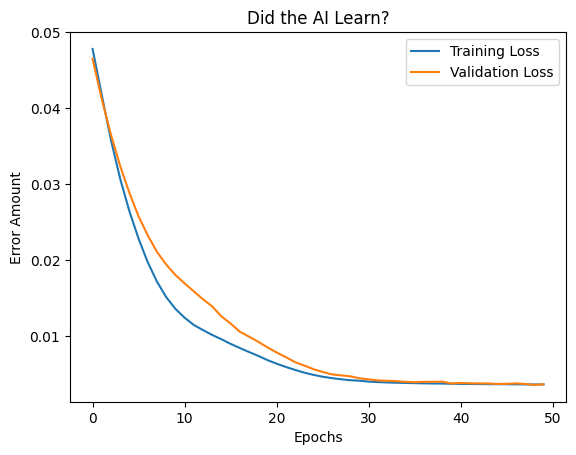

In [24]:
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense
import matplotlib.pyplot as plt


input_dim = X_train.shape[1]
encoding_dim = 2

input_layer = Input(shape=(input_dim,))

encoder = Dense(8, activation="relu")(input_layer)
bottleneck = Dense(encoding_dim, activation="relu")(encoder)

decoder = Dense(8, activation="relu")(bottleneck)
output_layer = Dense(input_dim, activation="sigmoid")(decoder)

autoencoder = Model(inputs=input_layer, outputs=output_layer)
autoencoder.compile(optimizer='adam', loss='mean_squared_error')

print("Starting Training...")

history = autoencoder.fit(X_train, X_train,
                          epochs=50,
                          batch_size=8,
                          shuffle=True,
                          validation_split=0.1,
                          verbose=1)

print("\nModel Trained!")

plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Did the AI Learn?')
plt.ylabel('Error Amount')
plt.xlabel('Epochs')
plt.legend()
plt.show()

##  **Step 4: Anomaly Detection Logic**
We calculate the **Mean Squared Error (MSE)** for every employee.

**Thresholding:**
* We set a dynamic threshold at the **95th Percentile**.
* This means we automatically flag the **top 5% most unusual behaviors** for review, assuming that 95% of the workforce is operating normally.

4. Detecting Anomalies...
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
   - Anomaly Threshold: 0.1050

FINAL RESULT: THE CAUGHT ANOMALIES
          Date         Label  Hours_Worked  Anomaly_Score
8   2024-01-11  Burnout Risk         14.11       0.110674
20  2024-01-29  Burnout Risk         13.63       0.118801
40  2024-02-26  Burnout Risk         11.83       0.141274
72  2024-01-17  Burnout Risk         14.87       0.167669
73  2024-01-18  Burnout Risk         11.64       0.106924
80  2024-01-29  Burnout Risk         13.21       0.145684
86  2024-02-06  Burnout Risk         14.66       0.122959
115 2024-03-18      Slacking          1.41       0.109194
166 2024-03-05  Burnout Risk         14.65       0.154801
170 2024-03-11      Slacking          1.05       0.114965


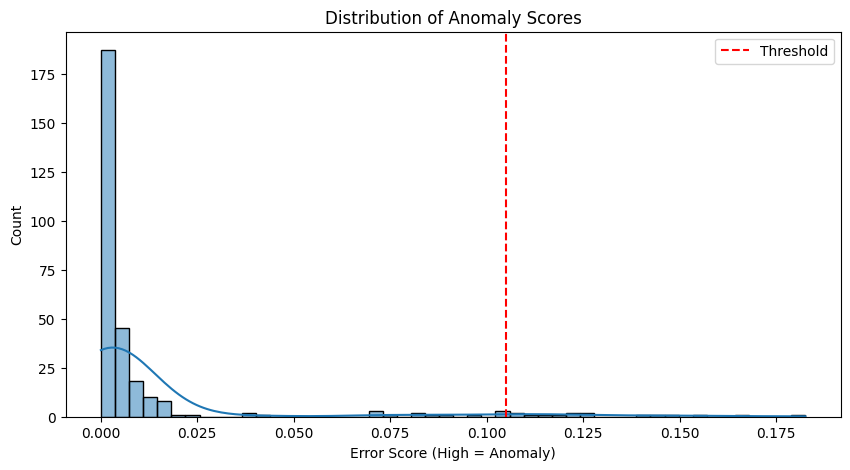

In [25]:
print("4. Detecting Anomalies...")

reconstructions = autoencoder.predict(X_test)

mse = np.mean(np.power(X_test - reconstructions, 2), axis=1)

df_final['Anomaly_Score'] = mse

threshold = np.percentile(mse, 95)
print(f"   - Anomaly Threshold: {threshold:.4f}")

suspects = df_final[df_final['Anomaly_Score'] > threshold]

print("\n" + "="*50)
print("FINAL RESULT: THE CAUGHT ANOMALIES")
print("="*50)

print(suspects[['Date', 'Label', 'Hours_Worked', 'Anomaly_Score']].head(10))

plt.figure(figsize=(10,5))
sns.histplot(mse, bins=50, kde=True)
plt.axvline(threshold, color='r', linestyle='--', label='Threshold')
plt.title('Distribution of Anomaly Scores')
plt.xlabel('Error Score (High = Anomaly)')
plt.legend()

##  **Step 5: The Auditor (NLP Semantic Analysis)**
Now we check for **Truthfulness** using Natural Language Processing.

We use **SBERT (Sentence-BERT)** to turn text into mathematical vectors.
* **Input:** Jira Task Description vs. Git Commit Message.
* **Metric:** Cosine Similarity.
    * Score > 0.5: **Verified Match** (The code matches the task).
    * Score < 0.5: **Mismatch** (Potential quiet quitting or falsified logs).

In [26]:
from sentence_transformers import SentenceTransformer, util
import torch

print("1. Loading SBERT Model...")
model = SentenceTransformer('all-mpnet-base-v2')

print("2. Reading Jira and Git logs...")

jira_texts = df_final['Jira_Task'].tolist()
git_texts = df_final['Git_Commit'].tolist()

# Convert task description and work log into numerical vectors
print("   - Encoding Jira Tasks ...")
jira_embeddings = model.encode(jira_texts, convert_to_tensor=True)

print("   - Encoding Git Commits...")
git_embeddings = model.encode(git_texts, convert_to_tensor=True)

print("3. Calculating Similarity Scores...")

# Cosine similarity measures semantic meaning, not exact word matching
cosine_scores = util.cos_sim(jira_embeddings, git_embeddings)

similarity_scores = cosine_scores.diagonal().cpu().numpy()

df_final['NLP_Similarity_Score'] = similarity_scores

print("\nNLP Analysis Complete!")
print(df_final[['Jira_Task', 'Git_Commit', 'NLP_Similarity_Score', 'Label']].head(10))

1. Loading SBERT Model...
2. Reading Jira and Git logs...
   - Encoding Jira Tasks ...
   - Encoding Git Commits...
3. Calculating Similarity Scores...

NLP Analysis Complete!
                        Jira_Task  \
0       Update React dependencies   
1            Add dark mode toggle   
2  Fix authentication memory leak   
3         Center the login button   
4  Fix authentication memory leak   
5  Fix authentication memory leak   
6     Implement API rate limiting   
7  Fix authentication memory leak   
8  Fix authentication memory leak   
9         Center the login button   

                                      Git_Commit  NLP_Similarity_Score  \
0     Ran npm audit fix and updated package.json              0.409615   
1  Added media queries for mobile responsiveness              0.069003   
2         Updated Dockerfile to python:3.11-slim             -0.028234   
3       Changed margin-left to auto in login.css              0.633779   
4                  Added Redis for rate limiti

##  **Step 6: Final Risk Dashboard**
We combine the **Behavioral Score** (Autoencoder) and the **Truth Score** (NLP) to classify employees into actionable categories.

**The 4 Risk Quadrants:**
1.  🟢 **Safe:** Normal Behavior + Matching Logs.
2.  🟠 **Burnout Risk:** High Anomaly Score (Overwork) + Matching Logs.
3.  🟣 **Suspicious:** Normal Behavior + Mismatched Logs.
4.  🔴 **Critical (Slacking/Fraud):** High Anomaly Score (Low Output) + Mismatched Logs.

Generating Final Risk Report...

TOP PRIORITY INVESTIGATIONS
          Date             Risk_Category  Hours_Worked  \
289 2024-03-08  CRITICAL: Slacking/Lying         15.38   
72  2024-01-17  CRITICAL: Slacking/Lying         14.87   
166 2024-03-05     WARNING: Burnout Risk         14.65   
177 2024-03-20  CRITICAL: Slacking/Lying         15.85   
80  2024-01-29  CRITICAL: Slacking/Lying         13.21   
40  2024-02-26  CRITICAL: Slacking/Lying         11.83   
296 2024-03-19  CRITICAL: Slacking/Lying          0.51   
192 2024-01-17  CRITICAL: Slacking/Lying          0.72   
282 2024-02-28  CRITICAL: Slacking/Lying          0.73   
86  2024-02-06  CRITICAL: Slacking/Lying         14.66   

                                   Jira_Task  \
289                     Add dark mode toggle   
72                 Update React dependencies   
166           Upgrade Python version to 3.11   
177           Upgrade Python version to 3.11   
80               Fix CSS grid on mobile view   
40          

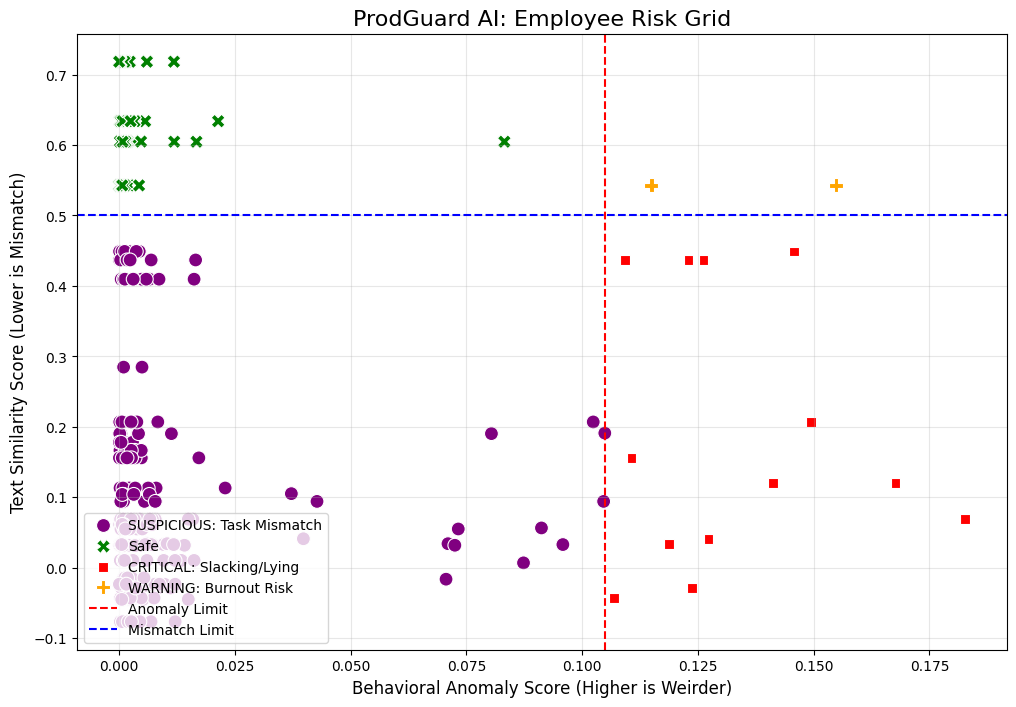

In [27]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

print("Generating Final Risk Report...")

anomaly_threshold = threshold
similarity_threshold = 0.5

def classify_risk(row):
    is_anomaly = row['Anomaly_Score'] > anomaly_threshold

    is_mismatch = row['NLP_Similarity_Score'] < similarity_threshold

    if is_anomaly and is_mismatch:
        return "CRITICAL: Slacking/Lying"
    elif is_anomaly and not is_mismatch:
        return "WARNING: Burnout Risk"
    elif not is_anomaly and is_mismatch:
        return "SUSPICIOUS: Task Mismatch"
    else:
        return "Safe"

df_final['Risk_Category'] = df_final.apply(classify_risk, axis=1)

print("\n" + "="*50)
print("TOP PRIORITY INVESTIGATIONS")
print("="*50)
risky_people = df_final[df_final['Risk_Category'] != 'Safe'].sort_values(by='Anomaly_Score', ascending=False)
print(risky_people[['Date', 'Risk_Category', 'Hours_Worked', 'Jira_Task', 'Git_Commit']].head(10))

plt.figure(figsize=(12, 8))

sns.scatterplot(
    data=df_final,
    x='Anomaly_Score',
    y='NLP_Similarity_Score',
    hue='Risk_Category',
    style='Risk_Category',
    palette={'Safe': 'green', 'CRITICAL: Slacking/Lying': 'red', 'WARNING: Burnout Risk': 'orange', 'SUSPICIOUS: Task Mismatch': 'purple'},
    s=100
)

plt.axvline(anomaly_threshold, color='red', linestyle='--', label='Anomaly Limit')
plt.axhline(similarity_threshold, color='blue', linestyle='--', label='Mismatch Limit')

plt.title('ProdGuard AI: Employee Risk Grid', fontsize=16)
plt.xlabel('Behavioral Anomaly Score (Higher is Weirder)', fontsize=12)
plt.ylabel('Text Similarity Score (Lower is Mismatch)', fontsize=12)
plt.legend(loc='lower left')
plt.grid(True, alpha=0.3)
plt.show()

##  **Conclusion: Model Showdown**
Final comparison between the Traditional ML (Isolation Forest) and our Deep Learning approach.

In [28]:
dl_catch = df_final[df_final['Anomaly_Score'] > threshold].shape[0]
iso_catch = df_final[df_final['IsoForest_Anomaly'] == 1].shape[0]

print(f"Final Results:")
print(f"1. Traditional ML (Isolation Forest) flagged: {iso_catch} people.")
print(f"2. Deep Learning (Autoencoder) flagged:       {dl_catch} people.")

if dl_catch > iso_catch:
    print("\nCONCLUSION: Deep Learning found hidden anomalies that the simple model missed!")
else:
    print("\nCONCLUSION: Both models agreed, validating the results.")

Final Results:
1. Traditional ML (Isolation Forest) flagged: 15 people.
2. Deep Learning (Autoencoder) flagged:       15 people.

CONCLUSION: Both models agreed, validating the results.


##  **Step 7: Exporting Actionable Intelligence**
Data Science is useless if it doesn't lead to action.

In this final step, we filter the dataset to find **only the employees who need attention** and export a clean report.

**The Report Columns:**
* **Risk_Category:** The diagnosis (Burnout vs. Slacking).
* **Anomaly_Score:** How "weird" their behavior was (Statistical).
* **NLP_Score:** How "truthful" their logs were (Semantic).
* **Evidence:** The specific Jira Task vs. Git Commit that caused the flag.

**Output:** `Manager_Risk_Report.csv` (Saved to local directory).

In [29]:
risky_people.to_csv('Manager_Risk_Report.csv', index=True)

print("Report saved! Look in your Colab 'Files' tab on the left.")

Report saved! Look in your Colab 'Files' tab on the left.
